# Evaluation of the polymorphic Gompertzian model on in vivo data

This code contains fitting of the polymorphic Gompertzian model to in vivo data of patients tumor dynamics, comparisson with fits of classical models of cancer growth and evaluation of the fit errors.

In [1]:
#Import required packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
from gekko import GEKKO
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats

In [144]:
#Load data
os.chdir('/Users/Arina/Desktop/Master Thesis/In vivo data')

study1 = pd.read_excel('invivodata.xlsx', sheet_name = "Study1")
study2 = pd.read_excel('invivodata.xlsx', sheet_name = "Study2")
study3 = pd.read_excel('invivodata.xlsx', sheet_name = "Study3")
study4 = pd.read_excel('invivodata.xlsx', sheet_name = "Study4")

In [184]:
# Filter data in the same way it was done in Narmin's paper
# Keep only patients with at least 6 time points
def FilterData(data):
    Data_filtered = pd.DataFrame(columns = data.columns)
    #PatientIDs = list(data['USUBJID'].unique())
    
    data['TargetLesionLongDiam_mm'] = pd.to_numeric(data['TargetLesionLongDiam_mm'], errors='coerce').replace('NaN',0)
    
    #data = data[pd.to_numeric(data['TargetLesionLongDiam_mm'], errors='coerce').replace('NaN',0)]

    PatientIDs = list(data['Patient_Anonmyized'].unique())
    
    for ID in PatientIDs:
        FilteredData = data.loc[data['Patient_Anonmyized'] == ID]
        
        VisitsN = len(FilteredData)
        if VisitsN >= 6:
            Data_filtered = pd.concat([Data_filtered, FilteredData])
        
    return Data_filtered
    

In [148]:
Study1_filtered = FilterData(study1)
Study2_filtered = FilterData(study2)
Study3_filtered = FilterData(study3)
Study4_filtered = FilterData(study4)
#Study5_filtered = FilterData(study5)

In [203]:
# Combine meassurments from all studies 
Data_full = np.zeros((590, 20))
tpoints_full = np.zeros((590, 20))

i = 0
for study in [Study1_filteredn, Study2_filteredn, Study3_filteredn, Study4_filteredn]:
    for ID in study['Patient_Anonmyized'].unique():
        PatientData = study[study['Patient_Anonmyized'] == ID]
        dimension = np.array(PatientData['TargetLesionLongDiam_mm'])

        volume = 0.52 * dimension*dimension*dimension
        time = np.array(PatientData['Treatment_Day'])
        volume = [x for _,x in sorted(zip(time,volume))]
        time = sorted(time) 
            
        Data_full[i, :len(volume)] = volume
        Data_full[i, len(volume):] = [None]*(20 - len(volume)) 
        tpoints_full[i, :len(time)] = time
        tpoints_full[i, len(time):] = [None]*(20 - len(time)) 
        
        i = i + 1

# Optimization problem 

In [198]:
# Function fits the model to tumor dynamics data of the patient
def FindIndParamsVivo(days, data, rho_init, gamma_init, K_init, K_ub, p_val, opt_init_prop = True):
    # define GEKKO model
    m = GEKKO(remote = False)
    
    m.time = days
    Exp_data = m.Param(data)

    rho = m.FV(value = rho_init, lb= 0)
    gamma = m.FV(value= gamma_init, lb = 0)
    if K_ub == -1:
        K = m.FV(value = K_init, lb = 0.9*max(data[:]))
    else:
        K = m.FV(value = K_init, lb = 0.9*max(data[:]),  ub = K_ub*max(data))
        
    rho.STATUS = 1
    gamma.STATUS = 1
    K.STATUS = 1 
    C = 1
    
    S0 = p_val*data[0]
    R0 = (1 - p_val)*data[0]

    S = m.Var(value = S0, lb = 0)
    R = m.Var(value = R0, lb = 0)
    
    # equations
    m.Equation(S.dt() == rho*(1-gamma*C)*m.log(K/(S+R))*S)
    m.Equation(R.dt() == rho*m.log(K/(S+R))*R)
    
    # objective
    m.Minimize(((Exp_data - (S+R)))**2)

    # application options 
    m.options.IMODE = 5 # dynamic estimation
    m.options.NODES = 5   # collocation nodes
    m.options.EV_TYPE = 2 # linear error (2 for squared)
    m.options.MAX_ITER = 1000
    
    m.solve(disp = False)
    
    error = m.options.OBJFCNVAL
    
    return np.array(S), np.array(R), error, K.value[0], rho.value[0], gamma.value[0]



In [199]:
#Function calculates solutions for different initial proportions of sensitive cells
# and returns the best fit
def FindBestSolInProps(Data, time, props, rho_init, K_init_val, Kub, gamma_init):
    
    volume = Data[~np.isnan(Data)]
    time = time[~np.isnan(Data)]
    K_init = max(volume)*K_init_val
    
    resS = np.zeros(20)
    resR = np.zeros(20)
    resK = 0
    resrho = 0
    resgamma = 0
    resprops = 0
    
    
    err_min = -1
    for p_val in props:
        try:
            S, R, error, K, rho, gamma = FindIndParamsVivo(time, volume, rho_init,
                                                           gamma_init, K_init, Kub, 
                                                           p_val)
            err = mean_squared_error(R+S, volume)
            if (err < err_min)|(err_min == -1) :
                resprops = p_val
                resS[:len(time)] = S
                resR[:len(time)] = R
                resK = K
                resrho = rho
                resgamma = gamma
                
                resS[len(time):] = [None] * (20 - len(time))
                resR[len(time):] = [None] * (20 - len(time))              

                err_min = err   
        except:
            pass
    return resS, resR, resK, resrho, resgamma, resprops, err_min

In [200]:
S_full = np.zeros((590, 20))
R_full = np.zeros((590, 20))
K_full = np.zeros((590))
rho_full = np.zeros((590))
gamma_full = np.zeros((590))
props_full = np.zeros((590))

In [244]:
# Obtain the model's fit for all patients

for k in range(0, 590):
    err_min = -1
    for Kub in [-1, 10, 100]:
        
        props = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
             0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1]
        rho_init = 0.001
        gamma_init = 2
        K_init =  10

        resS, resR, resK, resrho, resgamma, resprops, err = FindBestSolInProps(Data_full[k],
                                                                              tpoints_full[k], props, rho_init, K_init, Kub, gamma_init)
        if (err < err_min)|(err_min == -1):
            err_min = err
            S_full[k] = resS
            R_full[k] = resR
            K_full[k] = resK
            rho_full[k] = resrho
            gamma_full[k] = resgamma
            props_full[k] = resprops  
    print(k)  


267


In [194]:
#Function to plot dynamics of the data and the model fit 
def PlotSolutions(indxs, Data_full, tpoints_full, S_full, R_full, plotSR = False):
    
    plt.figure(figsize = (21, 50))

    k = 1
    for i in indxs:
        volume = Data_full[i, ~np.isnan(Data_full[i])]
        time = tpoints_full[i, ~np.isnan(tpoints_full[i])]

        ax = plt.subplot(10, 5, k)
        ax.plot(time, volume, 'x', color = 'darkorange', label ='Messured')
        ax.plot(tpoints_full[i], S_full[i]+R_full[i], label = 'Predicted N')
        if plotSR:
            ax.plot(tpoints_full[i], R_full[i], '--', label = 'Predicted R')
            ax.plot(tpoints_full[i], S_full[i], '--', label = 'Predicted S')
            
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True) 
        formatter.set_powerlimits((-1,1)) 
        ax.yaxis.set_major_formatter(formatter) 
        ax.legend()
        ax.set_xlabel('Time(days)')
        k = k+1
    
    plt.show()

In [245]:
np.where(K_full == 0)

(array([267]),)

In [247]:
# exclude 3 patients, for which the solution was not found

to_exclude = np.where(K_full == 0)
#to_exclude = [242, 483, 562]

Data_full = Data_full[[i for i in range(590) if i not in to_exclude]]
tpoints_full = tpoints_full[[i for i in range(590) if i not in to_exclude]]
S_full = S_full[[i for i in range(590) if i not in to_exclude]]
R_full = R_full[[i for i in range(590) if i not in to_exclude]]
rho_full = rho_full[[i for i in range(590) if i not in to_exclude]]
gamma_full = gamma_full[[i for i in range(590) if i not in to_exclude]]
props_full = props_full[[i for i in range(590) if i not in to_exclude]]
K_full = K_full[[i for i in range(590) if i not in to_exclude]]

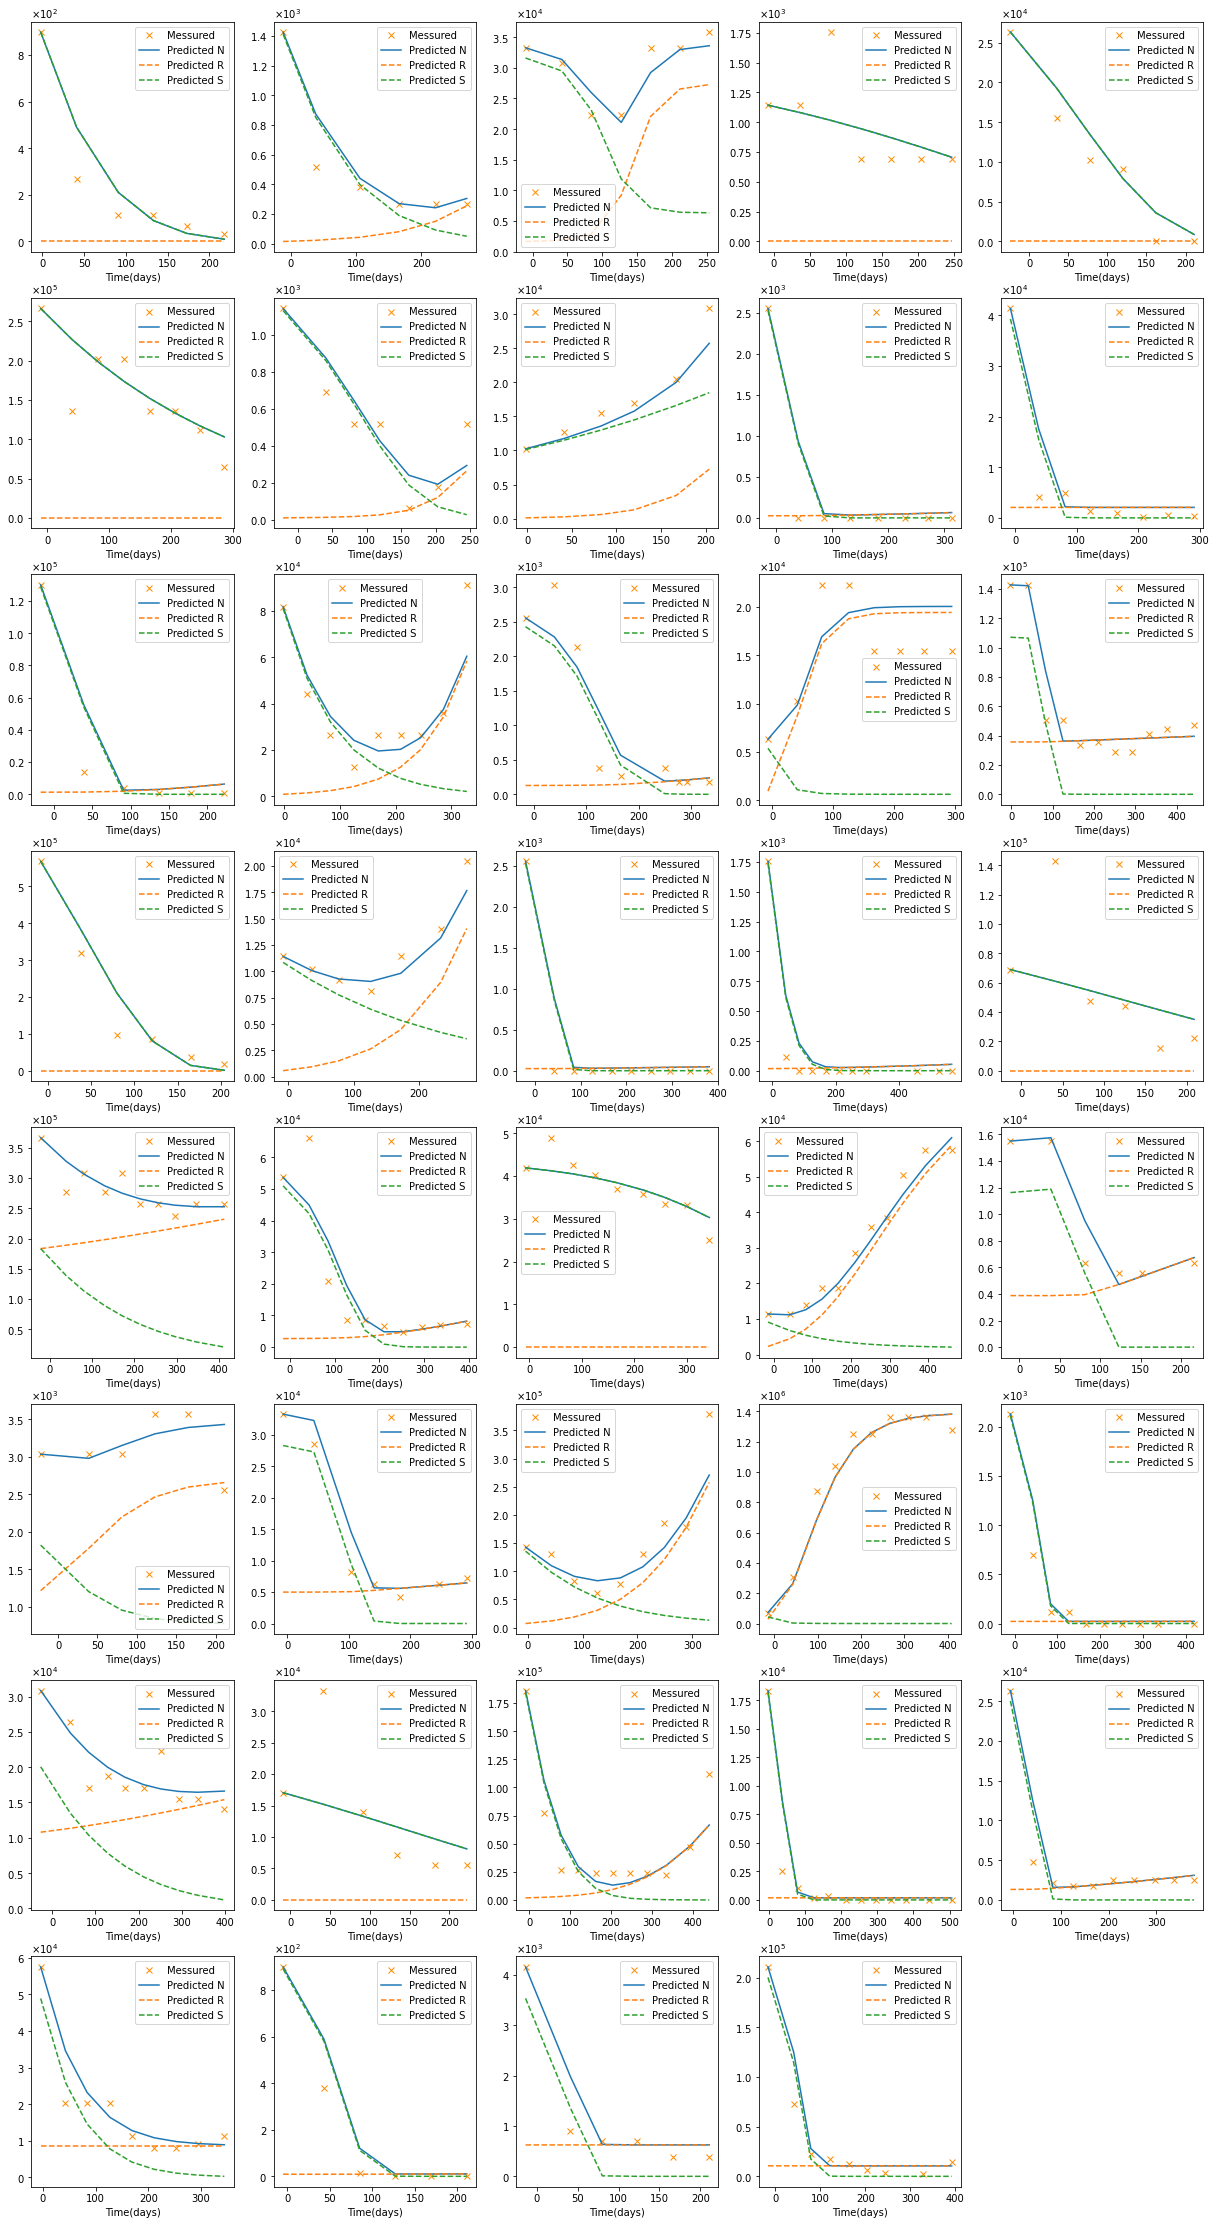

In [213]:
PlotSolutions(np.arange(0,39), Data_full, tpoints_full, S_full, R_full, plotSR = True)

# Analyze results statistically

In [248]:
#Normalized mean squared error
def nmse(x_mes, x_pred):
    x_pred = x_pred[~np.isnan(x_pred)]
    x_mes = x_mes[~np.isnan(x_mes)]
    if len(x_pred) == len(x_mes):
        err = sum(((x_mes-x_pred)/max(x_mes))**2)/len(x_mes)
        return err
    else:
        return 0

In [251]:
# Classify patinets into groups based on trend
def DetectTrend(Data_full, tpoints):
    trend = ["" for x in range(589)]
    for i in range(0, 589):
        volume = Data_full[i, ~np.isnan(Data_full[i])]
        time = tpoints[i, ~np.isnan(Data_full[i])]
        dif = np.diff(volume)
        if len(dif) == 0:
            print(volume)
        
        if all(dif >= 0) | ((dif[0] > 0) & (sum(dif[dif>0]) > 2* sum(abs(dif[dif<0])))):
            trend[i] = 'Monotonic growth'
        elif all(dif <= 0) | ((dif[0] < 0) & (2*sum(dif[dif>0]) < sum(abs(dif[dif<0])))):
            trend[i] = 'Monotonic decline'
        elif (dif[np.where(dif !=0)[0][0]] > 0) & (any(dif[np.where(dif !=0)[0]] < 0)) & (volume[-1]<volume[0]):
            trend[i] = 'Delayed response'
        elif any(np.diff(np.sign(dif[(abs(dif/(max(volume)-min(volume)))>0.1)])) == 2) & all(np.diff(np.sign(dif[(abs(dif/(max(volume)-min(volume)))>0.1)])) != -2):
            trend[i] = 'U-shape'
        else:
            trend[i] = 'Fluctuate'
    return trend   
        

In [252]:
trend_full = DetectTrend(Data_full, tpoints_full)

In [253]:
#trend_full = DetectTrend(Data_full, tpoints_full)    

indexesDR = [i for i,trend_full in enumerate(trend_full) if trend_full == 'Delayed response']
indexesU = [i for i,trend_full in enumerate(trend_full) if trend_full == 'U-shape']
indexesMG = [i for i,trend_full in enumerate(trend_full) if trend_full == 'Monotonic growth']
indexesMD = [i for i,trend_full in enumerate(trend_full) if trend_full == 'Monotonic decline']
indexesF = [i for i,trend_full in enumerate(trend_full) if trend_full == 'Fluctuate']

In [254]:
# Number of patients in each trend category
print('Delayed response: ' + str(len(indexesDR)))
print('U-shape: ' + str(len(indexesU)))
print('Growth: ' + str(len(indexesMG)))
print('Decline: ' + str(len(indexesMD)))
print('Fluctuate: ' + str(len(indexesF)))

Delayed response: 62
U-shape: 79
Growth: 101
Decline: 240
Fluctuate: 107


In [258]:
#Calculate errors
nMSE = np.zeros(589)
MSE = np.zeros(589)
MAE = np.zeros(589)
for i in range(589):
    nMSE[i] = nmse(Data_full[i, ~np.isnan(Data_full[i])], (S_full[i] + R_full[i])[~np.isnan(Data_full[i])])
    MSE[i] = mean_squared_error(Data_full[i, ~np.isnan(Data_full[i])], (S_full[i] + R_full[i])[~np.isnan(S_full[i] + R_full[i])])
    MAE[i] = mean_absolute_error(Data_full[i, ~np.isnan(Data_full[i])], (S_full[i] + R_full[i])[~np.isnan(S_full[i] + R_full[i])])
    
Errors = nMSE    
Errors = np.nan_to_num(Errors)

# Visualizations 

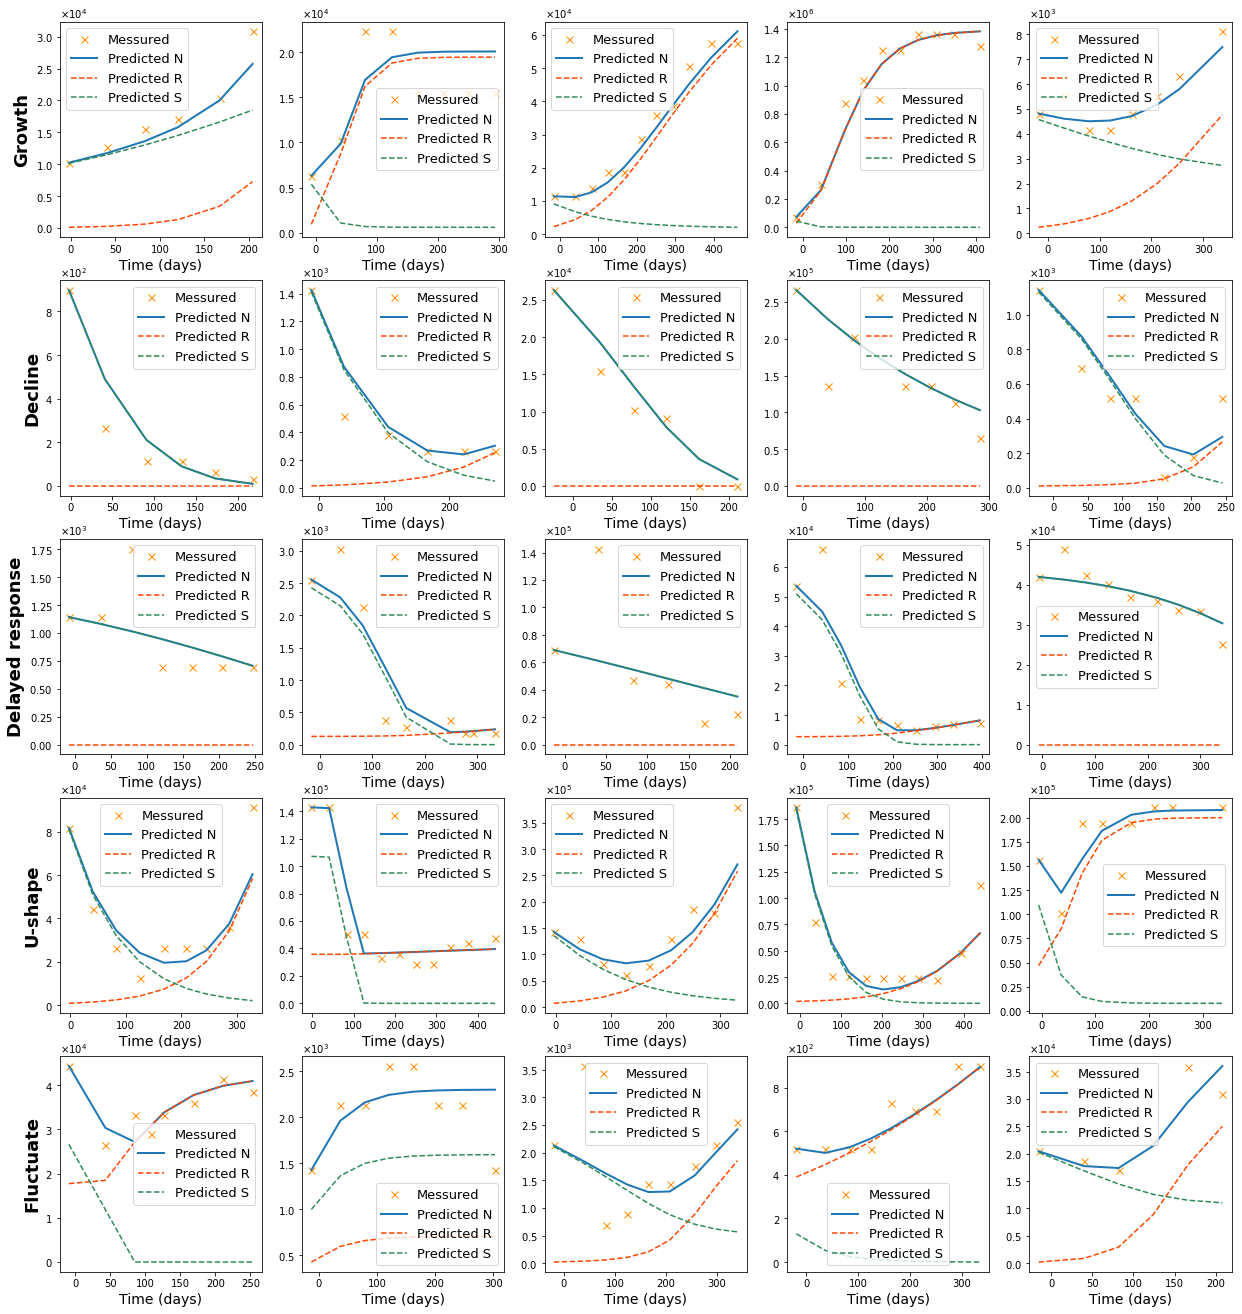

In [259]:
#Visualize dynamics across trend groups
indxs = [indexesMG[:5], indexesMD[:5], indexesDR[:5], indexesU[1:6], indexesF[10:15]]
indxs = np.array(indxs).flatten()

cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize = (21, 23))
plotSR = True

k = 1
for i in indxs:
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    
    ax = plt.subplot(5, 5, k)
    ax.plot(time, volume, 'x', markersize = 7, color = 'darkorange', label ='Messured')
    ax.plot(tpoints_full[i], S_full[i]+R_full[i], linewidth = 2, label = 'Predicted N')
    if plotSR:
        ax.plot(tpoints_full[i], R_full[i], color = 'orangered', linestyle = '--', label = 'Predicted R')
        ax.plot(tpoints_full[i], S_full[i], color = 'seagreen', linestyle = '--', label = 'Predicted S')
        
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
        
    ax.legend(fontsize = 13)
    ax.set_xlabel('Time (days)', size = 14)
    #ax.set_ylabel('Tumor volume ($mm^3$)')
    classification = ['Growth', 'Decline', 'Delayed response', 'U-shape', 'Fluctuate']
    if ((k-1)%5 == 0):
        ax.set_ylabel(classification[int((k-1)/5)], weight = 'bold', size = 18)
    k = k+1
    
plt.show()
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/FIG3.jpg',
           dpi = 500, bbox_inches = "tight")
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for PLOS/FIG4.tiff', 
            dpi=600, format="tiff", bbox_inches = "tight")

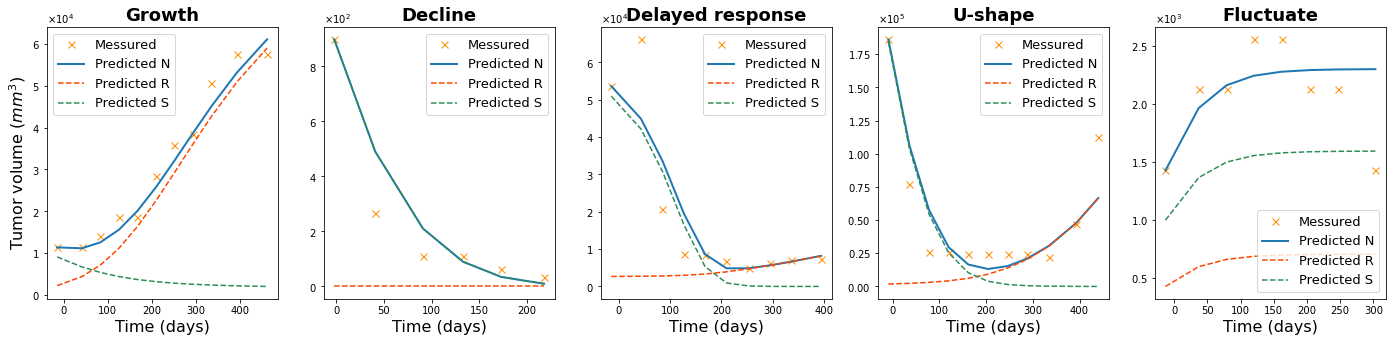

In [98]:
#Visualize dynamics across trend groups
indxs = [indexesMG[1], indexesMD[1], indexesDR[2], indexesU[3], indexesF[11]]
indxs = np.array(indxs).flatten()

cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize = (24, 5))
plotSR = True

k = 1
for i in indxs:
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    
    ax = plt.subplot(1, 5, k)
    ax.plot(time, volume, 'x', markersize = 7, color = 'darkorange', label ='Messured')
    ax.plot(tpoints_full[i], S_full[i]+R_full[i], linewidth = 2, label = 'Predicted N')
    if plotSR:
        ax.plot(tpoints_full[i], R_full[i], color = 'orangered', linestyle = '--', label = 'Predicted R')
        ax.plot(tpoints_full[i], S_full[i], color = 'seagreen', linestyle = '--', label = 'Predicted S')
        
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
        
    ax.legend(fontsize = 13)
    ax.set_xlabel('Time (days)', size = 16)
    if k ==1:
        ax.set_ylabel('Tumor volume ($mm^3$)', size = 16)
    classification = ['Growth', 'Decline', 'Delayed response', 'U-shape', 'Fluctuate']
    #if ((k-1)%5 == 0):
    ax.set_title(classification[k-1], weight = 'bold', size = 18)
    k = k+1
    
plt.show()
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/Fig_present.jpg',
           dpi = 500, bbox_inches = "tight")

In [260]:
#function to add significance bars to the distribution plots
def plotStats(data, n, height= 0.1, b = None, t = None):
    data = pd.DataFrame(data)
    data = data.transpose()
    significant_combinations = []
    
    # Check from the outside pairs of boxes inwards
    ls = list(range(1, np.shape(data)[1] + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    for combination in combinations:
        data1 = data[combination[0] - 1].dropna()
        data2 = data[combination[1] - 1].dropna()
    # Significance
        U, p = stats.ttest_ind(data1, data2, equal_var = False)
        if p < 0.05:
            significant_combinations.append([combination, p])
    
    # Get the y-axis limits
    if (b != None) & (t != None):
        bottom, top = b, t
    elif n != 0:
        bottom, top = eval('ax'+str(n)).get_ylim()
    else:
        bottom, top = plt.ylim()
    y_range = top - bottom

    # Significance bars
    
    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (y_range * 0.1 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.005)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')   


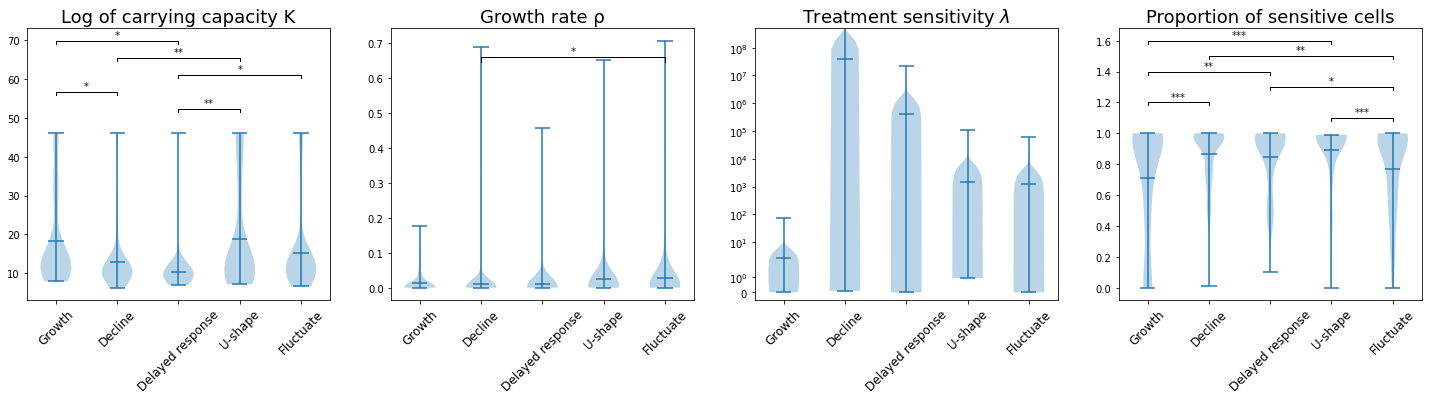

In [261]:
#Distribution of the model's parameters across trend categories
fig = plt.figure(figsize=(25, 5))

ax1 = plt.subplot(1,4,1)
ax1.violinplot([np.log(K_full[indexesMG]), np.log(K_full[indexesMD]),
                np.log(K_full[indexesDR]), np.log(K_full[indexesU]),
                np.log(K_full[indexesF])][::-1],
              positions =[5,4,3,2,1],vert=True,showmeans=True)
ax1.set_xticks([1,2,3,4,5]) 
ax1.set_xticklabels(['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=12, rotation = 45)

ax1.set_title('Log of carrying capacity K', size = 18)
plotStats([K_full[indexesMG], K_full[indexesMD],
                K_full[indexesDR], K_full[indexesU],
                K_full[indexesF]], 1)

ax2 = plt.subplot(1,4,2)
ax2.violinplot([rho_full[indexesMG],rho_full[indexesMD],rho_full[indexesDR],
                rho_full[indexesU],rho_full[indexesF]][::-1],
              positions =[5,4,3,2,1],vert=True,showmeans=True)
ax2.set_xticks([1,2,3,4,5]) 
ax2.set_xticklabels(['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=12, rotation = 45)
plotStats([rho_full[indexesMG],rho_full[indexesMD],rho_full[indexesDR],
                rho_full[indexesU],rho_full[indexesF]], 2, 0.1, 0, 0.6)

ax2.set_title('Growth rate ' + chr(961), size =18)

ax3 = plt.subplot(1,4,3)
ax3.violinplot([gamma_full[indexesMG],gamma_full[indexesMD],gamma_full[indexesDR],
                gamma_full[indexesU],gamma_full[indexesF]][::-1],
              positions =[5,4,3,2,1],vert=True,showmeans=True)
ax3.set_xticks([1,2,3,4,5]) 
ax3.set_xticklabels(['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=12, rotation = 45)
ax3.set_yscale('symlog')
plotStats([gamma_full[indexesMG],gamma_full[indexesMD],gamma_full[indexesDR],
                gamma_full[indexesU],gamma_full[indexesF]], 3)
data = pd.DataFrame([gamma_full[indexesMG],gamma_full[indexesMD],gamma_full[indexesDR],
               gamma_full[indexesU],gamma_full[indexesF]])
data = data.transpose()
significant_combinations = []
    
    # Check from the outside pairs of boxes inwards
ls = list(range(1, np.shape(data)[1] + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    data1 = data[combination[0] - 1].dropna()
    data2 = data[combination[1] - 1].dropna()
    # Significance
    U, p = stats.ttest_ind(data1, data2, equal_var = False)
    if p < 0.01:
        significant_combinations.append([combination, p])
    
    # Get the y-axis limits
bottom, top = ax3.get_ylim() 
y_range = top - bottom

    # Significance bars
    
for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
        # Plot the bar
    bar_height = (y_range * 0.1* 10 ** level) + top
    bar_tips = bar_height - (y_range * 0.5* 10 ** (level-1))
    plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.5)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')   


ax3.set_yscale('symlog')
ax3.set_ylim([-0.5, 5*10**8])
ax3.set_title('Treatment sensitivity $\lambda$', size =18)

ax4 = plt.subplot(1,4,4)
ax4.violinplot([props_full[indexesMG],props_full[indexesMD],props_full[indexesDR],
                props_full[indexesU],props_full[indexesF]][::-1],
              positions =[5,4,3,2,1],vert=True,showmeans=True)
ax4.set_xticks([1,2,3,4,5]) 
ax4.set_xticklabels(['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=12, rotation = 45)
plotStats([props_full[indexesMG],props_full[indexesMD],props_full[indexesDR],
                props_full[indexesU],props_full[indexesF]], 4, 0.02, 0, 1)
ax4.set_title('Proportion of sensitive cells', size =18)

plt.show()
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/FIG4.jpg',
           dpi = 500, bbox_inches = "tight")

# T-tests

In [262]:
# Compare K values in different trend categories
K_comp = pd.DataFrame(columns = ['Growth', 'Decline', 'Delayed response',
                                 'U-shape', "Fluctuate"], index = ['Growth', 'Decline', 'Delayed response',
                                 'U-shape', "Fluctuate"])

group = ['MG', 'MD', 'DR', 'U', 'F']

for i in np.arange(5):
    for j in np.arange(5):
        _, p = stats.ttest_ind(K_full[eval('indexes'+group[i])],
                               K_full[eval('indexes'+group[j])],
                equal_var = False)
        if p < 0.05:
            K_comp.iloc[i,j] = str('{:g}'.format(float('{:.{n}g}'.format(p, n=1))))+'*'
        else:
            K_comp.iloc[i,j] = '{:g}'.format(float('{:.{n}g}'.format(p, n=1)))
        
K_comp

,Growth,Decline,Delayed response,U-shape,Fluctuate
Growth,1,0.03*,0.02*,0.3,0.7
Decline,0.03*,1,0.6,0.005*,0.07
Delayed response,0.02*,0.6,1,0.003*,0.05*
U-shape,0.3,0.005*,0.003*,1,0.2
Fluctuate,0.7,0.07,0.05*,0.2,1


In [37]:
# Compare rho values in different trend categories
rho_comp = pd.DataFrame(columns = ['Growth', 'Decline', 'Delayed response',
                                 'U-shape', "Fluctuate"], index = ['Growth', 'Decline', 'Delayed response',
                                 'U-shape', "Fluctuate"])

group = ['MG', 'MD', 'DR', 'U', 'F']

for i in np.arange(5):
    for j in np.arange(5):
        _, p = stats.ttest_ind(rho_full[eval('indexes'+group[i])],
                               rho_full[eval('indexes'+group[j])],
                               equal_var = False)
       
        if p < 0.05:
            rho_comp.iloc[i,j] = str('{:g}'.format(float('{:.{n}g}'.format(p, n=1))))+'*'
        else:
            rho_comp.iloc[i,j] = '{:g}'.format(float('{:.{n}g}'.format(p, n=1)))
        
rho_comp

,Growth,Decline,Delayed response,U-shape,Fluctuate
Growth,1,0.01*,0.7,0.3,0.1
Decline,0.01*,1,0.4,0.03*,0.005*
Delayed response,0.7,0.4,1,0.2,0.1
U-shape,0.3,0.03*,0.2,1,0.8
Fluctuate,0.1,0.005*,0.1,0.8,1


In [72]:
# Compare lambda values in different trend categories
gamma_comp = pd.DataFrame(columns = ['Growth', 'Decline', 'Delayed response',
                                 'U-shape', "Fluctuate"], index = ['Growth', 'Decline', 'Delayed response',
                                 'U-shape', "Fluctuate"])

group = ['MG', 'MD', 'DR', 'U', 'F']

for i in np.arange(5):
    for j in np.arange(5):
        _, p = stats.ttest_ind(gamma_full[eval('indexes'+group[i])],
                               gamma_full[eval('indexes'+group[j])],
                equal_var = False)
        
        if p < 0.05:
            gamma_comp.iloc[i,j] = str('{:g}'.format(float('{:.{n}g}'.format(p, n=1))))+'*'
        else:
            gamma_comp.iloc[i,j] = '{:g}'.format(float('{:.{n}g}'.format(p, n=1)))
        
gamma_comp

,Growth,Decline,Delayed response,U-shape,Fluctuate
Growth,1,0.03*,0.3,0.2,0.1
Decline,0.03*,1,0.3,0.04*,0.03*
Delayed response,0.3,0.3,1,0.3,0.3
U-shape,0.2,0.04*,0.3,1,0.7
Fluctuate,0.1,0.03*,0.3,0.7,1


In [39]:
# Compare initial proportions of sensitive cells values in different trend categories
props_comp = pd.DataFrame(columns = ['Growth', 'Decline', 'Delayed response',
                                 'U-shape', "Fluctuate"], index = ['Growth', 'Decline', 'Delayed response',
                                 'U-shape', "Fluctuate"])

group = ['MG', 'MD', 'DR', 'U', 'F']

for i in np.arange(5):
    for j in np.arange(5):
        _, p = stats.ttest_ind(props_full[eval('indexes'+group[i])],
                                props_full[eval('indexes'+group[j])],
                equal_var = False)
        if p < 0.05:
            props_comp.iloc[i,j] = str('{:g}'.format(float('{:.{n}g}'.format(p, n=1))))+'*'
        else:
            props_comp.iloc[i,j] = '{:g}'.format(float('{:.{n}g}'.format(p, n=1)))
        
        
props_comp

,Growth,Decline,Delayed response,U-shape,Fluctuate
Growth,1,4e-05*,0.0006*,4e-05*,0.1
Decline,4e-05*,1,0.8,0.5,0.002*
Delayed response,0.0006*,0.8,1,0.5,0.02*
U-shape,4e-05*,0.5,0.5,1,0.002*
Fluctuate,0.1,0.002*,0.02*,0.002*,1


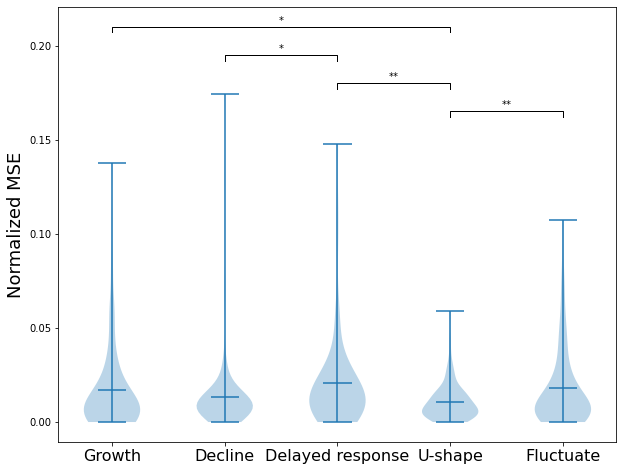

In [46]:
# Normalized MSE of the model's fits across five trend categories
plt.figure(figsize=(10, 8))
plt.violinplot([Errors[indexesMG], Errors[indexesMD], Errors[indexesDR],
                Errors[indexesU], Errors[indexesF]][::-1],
               positions =[5,4,3,2,1],vert=True,showmeans=True)
plt.xticks([1,2,3,4,5], ['Growth', 'Decline', 'Delayed response',
                     'U-shape', 'Fluctuate'], fontsize=16)
plt.ylabel('Normalized MSE', size = 18)
plotStats([Errors[indexesMG], Errors[indexesMD], Errors[indexesDR],
                Errors[indexesU], Errors[indexesF]], 0, 0.0001, 0, 0.15)
 
plt.show()

In [35]:
stats.mannwhitneyu(Errors[indexesMG], Errors[indexesMD]) #, alternative = "greater")

MannwhitneyuResult(statistic=9239.0, pvalue=0.0023431578863248002)

In [240]:
#Check statistical significance of differences between categories
stats.ttest_ind(Errors[indexesDR], Errors[indexesU],
                equal_var = False, alternative = "greater")

Ttest_indResult(statistic=3.7386644837614855, pvalue=0.00016588466664569574)

In [37]:
stats.ttest_ind(Errors[indexesU], Errors[indexesDR], alternative = "less")

Ttest_indResult(statistic=-4.012825030683989, pvalue=4.804716453418267e-05)

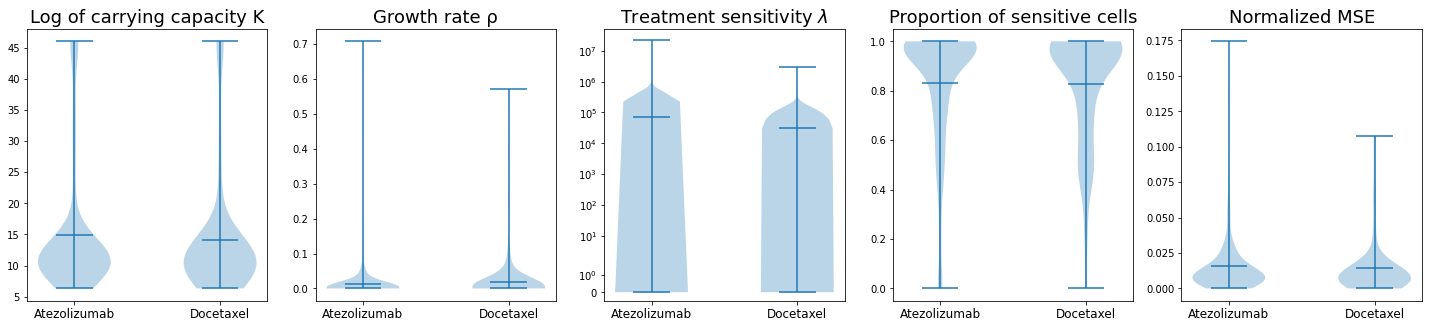

In [47]:
# Difference in parameter values and fitting errors between drug groups
plt.figure(figsize=(25, 5)) 

ax1 = plt.subplot(1,5,1)
ax1.violinplot([np.log(K_full[Drugs == 1]), np.log(K_full[Drugs == 2])][::-1],
               positions =[2,1], vert = True, showmeans = True)
ax1.set_xticks([1,2]) 
ax1.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax1.set_title('Log of carrying capacity K', size = 18)

ax2 = plt.subplot(1,5,2)
ax2.violinplot([rho_full[Drugs == 1], rho_full[Drugs == 2]][::-1],
               positions =[2,1], vert = True, showmeans = True)
ax2.set_xticks([1,2]) 
ax2.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax2.set_title('Growth rate ' + chr(961), size =18)

ax3 = plt.subplot(1,5,3)
ax3.violinplot([gamma_full[Drugs == 1], gamma_full[Drugs == 2]][::-1],
               positions =[2,1], vert = True, showmeans = True)
ax3.set_yscale('symlog')
ax3.set_ylim([-0.5, 5*10**7])
ax3.set_xticks([1,2]) 
ax3.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax3.set_title('Treatment sensitivity $\lambda$', size =18)

ax4 = plt.subplot(1,5,4)
ax4.violinplot([props_full[Drugs == 1], props_full[Drugs == 2]][::-1],
               positions =[2,1], vert = True, showmeans = True)
ax4.set_xticks([1,2]) 
ax4.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax4.set_title('Proportion of sensitive cells', size =18)

ax5 = plt.subplot(1,5,5)
ax5.violinplot([Errors[Drugs == 1], Errors[Drugs == 2]][::-1], positions =[2,1],
               vert = True, showmeans = True)
ax5.set_xticks([1,2]) 
ax5.set_xticklabels(['Atezolizumab', 'Docetaxel'], fontsize=12)
ax5.set_title('Normalized MSE', size =18)
                
plt.show()

In [39]:
stats.bartlett(gamma_full[Drugs == 1], gamma_full[Drugs == 2])

BartlettResult(statistic=199.70156527319142, pvalue=2.4263713643518965e-45)

In [40]:
stats.ttest_ind(gamma_full[Drugs == 1], gamma_full[Drugs == 2], equal_var = True)

Ttest_indResult(statistic=0.42045404915431034, pvalue=0.6743081895277073)

In [41]:
stats.mannwhitneyu(gamma_full[Drugs == 1], gamma_full[Drugs == 2], alternative = "less")

MannwhitneyuResult(statistic=26184.5, pvalue=0.09551484617319633)

# Comparing with classical models of cancer growth

In [29]:
# Function to fit General Gompertz model to data
def FitGeneralGompertz(days, data, d, g, l):
    # define GEKKO model
    m = GEKKO(remote = False)
    data = m.Param(data)
    m.time = days

    d = m.FV(value = d, lb = -5, ub = 5) 
    g = m.FV(value = g, lb = -5, ub = 5)
    l = m.FV(value = l, lb = -1, ub = 3)
    
    d.STATUS = 1
    g.STATUS = 1 
    l.STATUS = 1
    
    V = m.Var(data[0], lb = 0)
    
    # equations
    m.Equation(V.dt() == (V**l)*(d - g*m.log(V)))
    
    m.Minimize((V - data)**2)

    # application options 
    m.options.IMODE = 5 # dynamic estimation
    m.options.NODES = 5  # collocation nodes
    m.options.EV_TYPE = 2 # linear error (2 for squared)
    
    m.solve(disp = False)
    error = m.options.OBJFCNVAL
    
    return np.array(V), d.value[0], g.value[0], l.value[0]

In [30]:
# Function to fit General von Bertalanffy model to data
def FitGeneralBertalanffy(days, data, a, b, l):
    # define GEKKO model
    m = GEKKO(remote = False)
    data = m.Param(data)
    
    m.time = days

    a = m.FV(value = a)
    b = m.FV(value = b)
    l = m.FV(value = l)
    
    a.STATUS = 1
    b.STATUS = 1 
    l.STATUS = 1
    
    V = m.Var(data[0], lb = 0)
    
    #step = [0 if z<0 else 2 for z in m.time]
    
    # equations
    m.Equation(V.dt() == a*(V**l) - b*V)
    
    m.Minimize((V - data)**2)

    # application options 
    m.options.IMODE = 5 # dynamic estimation
    m.options.NODES = 5  # collocation nodes
    m.options.EV_TYPE = 2 # linear error (2 for squared)
    
    m.options.MAX_ITER = 500
    m.solve(disp = False)
    error = m.options.OBJFCNVAL
    
    return np.array(V), a.value[0], b.value[0], l.value[0]

In [31]:
a_full = np.zeros(590)
b_full = np.zeros(590)
l_full = np.zeros(590)
VGenBer_full = np.zeros((590, 20))


In [48]:
# TAKES VERY LONG TIME!
a_s = np.linspace(-10, 10, 20)
b_s = np.linspace(-10, 10, 20)

for i in range(0, 590):
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    

    err_min = -1
    a_prev= 0
    b_prev = 0
    l_prev = 0 
    VGenBer_prev = 0 

    for a in a_s:
        for b in b_s:
            try:
                VGenBer, a, b, l = FitGeneralBertalanffy(time, volume, a, b,1)
                err = mean_squared_error(VGenBer, volume)
                if (err < err_min) | (err_min == -1):
                    a_prev = a
                    b_prev = b
                    l_prev = l
                    VGenBer_prev = VGenBer
                    err_min = err
            except:
                pass
    if (type(VGenBer_prev) != int):
        a_full[i] = a_prev
        b_full[i] = b_prev
        l_full[i] = l_prev
        VGenBer_full[i, :len(VGenBer_prev)] = VGenBer_prev
        VGenBer_full[i, len(VGenBer_prev):] = [None]*(20 - len(VGenBer_prev))
        print(i)



64


In [62]:
#np.where(a_full == 0)
np.where(l_full == 0)[0]

array([242, 483, 562])

In [59]:
#d_GenGomp_full = np.zeros(590)
#g_GenGomp_full = np.zeros(590)
#l_GenGomp_full = np.zeros(590)
#VGenGomp_full = np.zeros((590, 20))

d_s = np.linspace(-10, 10, 20)
g_s = np.linspace(-10, 10, 20)

In [60]:
#TAKES VERY LONG TIME!

for i in range(0, 590):
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    
    err_min =-1
    d_prev= 0
    g_prev = 0
    l_prev = 0
    VGenGomp_prev = 0 

    for d in d_s:
        for g in g_s:
            try:
                VGenGomp, d, g, l = FitGeneralGompertz(time, volume, d, g, 1)
                #print('done')
                err = mean_squared_error(VGenGomp, volume)
                if (err < err_min) | (err_min == -1):
                    d_prev = d
                    g_prev = g
                    l_prev = l
                    VGenGomp_prev = VGenGomp
                    err_min = err
            except:
                pass
    if (type(VGenGomp_prev) != int):
        d_GenGomp_full[i] = d_prev
        g_GenGomp_full[i] = g_prev
        l_GenGomp_full[i] = l_prev
        VGenGomp_full[i, :len(VGenGomp_prev)] = VGenGomp_prev
        VGenGomp_full[i, len(VGenGomp_prev):] = [None]*(20 - len(VGenGomp_prev))
        print(i)

30
363
502


In [61]:
np.where(l_GenGomp_full == 0)

(array([242, 483, 562]),)

In [72]:

a_full = a_full[[i for i in range(590) if i not in to_exclude]]
b_full = b_full[[i for i in range(590) if i not in to_exclude]]
l_full = l_full[[i for i in range(590) if i not in to_exclude]]
VGenBer_full = VGenBer_full[[i for i in range(590) if i not in to_exclude]]

d_GenGomp_full = d_GenGomp_full[[i for i in range(590) if i not in to_exclude]]
g_GenGomp_full = g_GenGomp_full[[i for i in range(590) if i not in to_exclude]]
l_GenGomp_full = l_GenGomp_full[[i for i in range(590) if i not in to_exclude]]
VGenGomp_full = VGenGomp_full[[i for i in range(590) if i not in to_exclude]]

In [52]:
np.shape(VGenBer_full)

(587, 20)

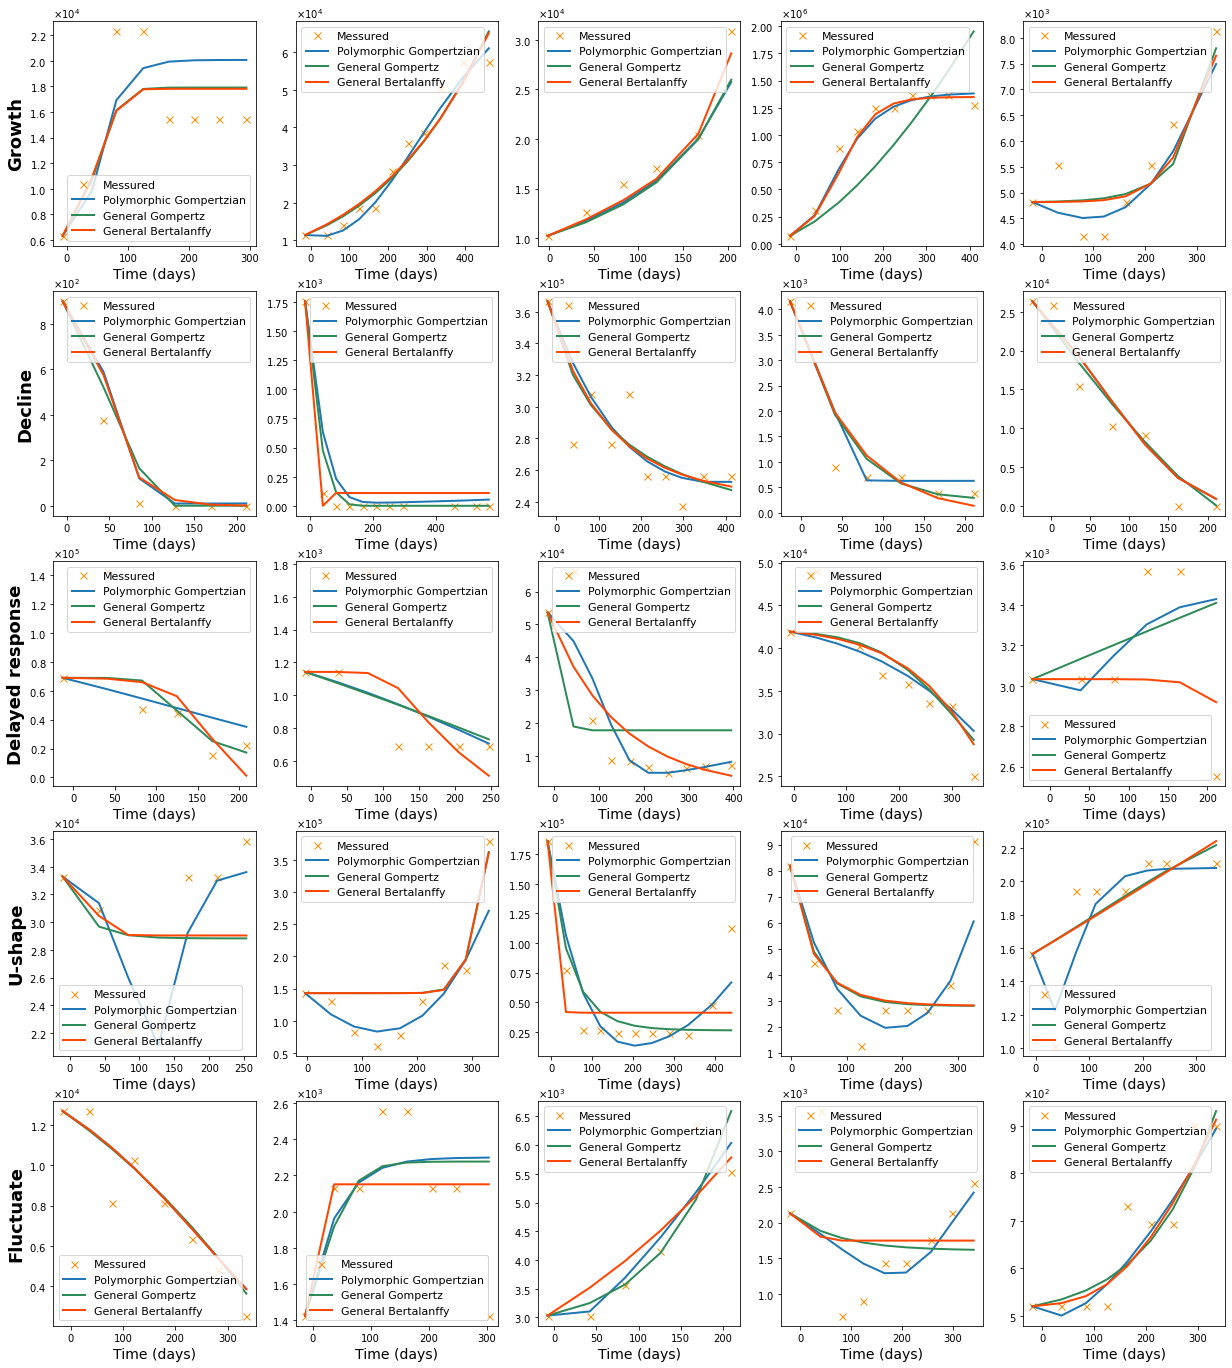

In [39]:
#Visualize dynamics of three models across trend categories
indxs = [indexesMG[:5], indexesMD[5:10], indexesDR[:5], indexesU[1:6], indexesF[10:15]]
indxs = np.array(indxs).flatten()

fig = plt.figure(figsize = (21, 24))
plotSR = True

k = 1
for i in indxs:
    volume = Data_full[i, ~np.isnan(Data_full[i])]
    time = tpoints_full[i, ~np.isnan(tpoints_full[i])]
    
    ax = plt.subplot(5, 5, k)
    ax.plot(time, volume, 'x', markersize = 7, color = 'darkorange', label ='Messured')
    ax.plot(tpoints_full[i], S_full[i]+R_full[i], color = 'tab:blue', linewidth = 2, label = 'Polymorphic Gompertzian')
    ax.plot(tpoints_full[i], VGenGomp_full[i], color = 'seagreen', linewidth = 2, label = 'General Gompertz')
    ax.plot(tpoints_full[i], VGenBer_full[i], color = 'orangered', linewidth = 2, label = 'General Bertalanffy')
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
    #if (k-1)%5 == 0:    
    ax.legend(fontsize = 11)
    ax.set_xlabel('Time (days)', size = 14)
    #ax.set_ylabel('Tumor volume ($mm^3$)')
    classification = ['Growth', 'Decline', 'Delayed response', 'U-shape', 'Fluctuate']
    if ((k-1)%5 == 0):
        ax.set_ylabel(classification[int((k-1)/5)], weight = 'bold', size = 18)
    k = k+1
    
plt.show()
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/FIG5.jpg',
           dpi = 500, bbox_inches = "tight")
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for PLOS/FIG5.tiff', 
            dpi=600, format="tiff", bbox_inches = "tight")

In [53]:
#Calculate errors
nMSE_GenGomp = np.zeros(587)
MSE_GenGomp = np.zeros(587)
MAE_GenGomp = np.zeros(587)

nMSE_GenBer = np.zeros(587)
MSE_GenBer = np.zeros(587)
MAE_GenBer = np.zeros(587)

for i in range(587):
    nMSE_GenGomp[i] = nmse(Data_full[i, ~np.isnan(Data_full[i])], VGenGomp_full[i, ~np.isnan(Data_full[i])])
    MSE_GenGomp[i] = mean_squared_error(Data_full[i, ~np.isnan(Data_full[i])], VGenGomp_full[i, ~np.isnan(Data_full[i])])
    MAE_GenGomp[i] = mean_absolute_error(Data_full[i, ~np.isnan(Data_full[i])], VGenGomp_full[i, ~np.isnan(Data_full[i])])

    nMSE_GenBer[i] = nmse(Data_full[i, ~np.isnan(Data_full[i])], VGenBer_full[i, ~np.isnan(Data_full[i])])
    MSE_GenBer[i] = mean_squared_error(Data_full[i, ~np.isnan(Data_full[i])], VGenBer_full[i, ~np.isnan(Data_full[i])])
    MAE_GenBer[i] = mean_absolute_error(Data_full[i, ~np.isnan(Data_full[i])], VGenBer_full[i, ~np.isnan(Data_full[i])])

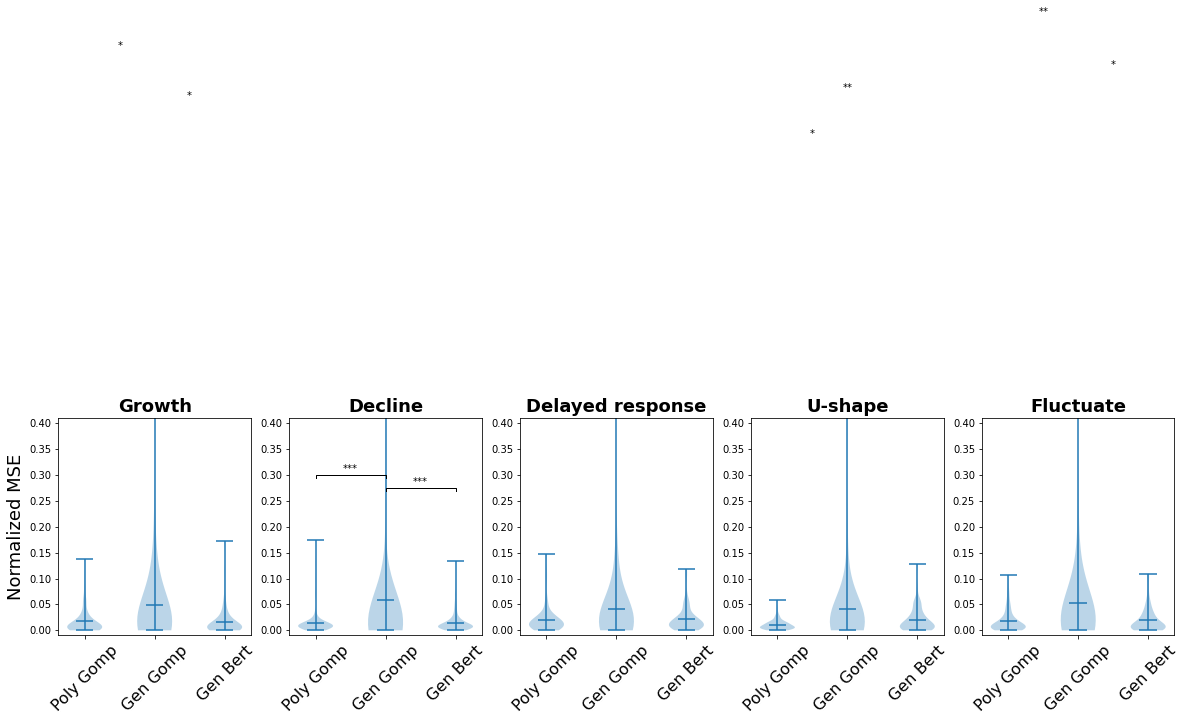

In [55]:
# Errors of the models fits acros trend categories
fig = plt.figure(figsize=(20, 4)) 

ax1 = plt.subplot(1,5,1)
ax1.violinplot([nMSE[indexesMG], nMSE_GenGomp[indexesMG], nMSE_GenBer[indexesMG]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['Poly Gomp', 'Gen Gomp',
                     'Gen Bert'], rotation = 45, fontsize=16)
ax1.set_title('Growth', weight = 'bold', size = 18)
ax1.set_ylabel('Normalized MSE', size = 18)

plotStats([nMSE[indexesMG], nMSE_GenGomp[indexesMG], nMSE_GenBer[indexesMG]], 1)
ax1.set_ylim([-0.01, 0.41])

ax2 = plt.subplot(1,5,2)
ax2.violinplot([nMSE[indexesMD], nMSE_GenGomp[indexesMD], nMSE_GenBer[indexesMD]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax2.set_xticks([1,2,3]) 
ax2.set_xticklabels(['Poly Gomp', 'Gen Gomp',
                     'Gen Bert'], rotation = 45, fontsize=16)
ax2.set_title('Decline', weight = 'bold', size = 18)
plotStats([nMSE[indexesMD], nMSE_GenGomp[indexesMD], nMSE_GenBer[indexesMD]],2, 0.1, 0, 0.25)
ax2.set_ylim([-0.01, 0.41])

ax3 = plt.subplot(1,5,3)
ax3.violinplot([nMSE[indexesDR], nMSE_GenGomp[indexesDR], nMSE_GenBer[indexesDR]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax3.set_xticks([1,2,3]) 
ax3.set_xticklabels(['Poly Gomp', 'Gen Gomp',
                     'Gen Bert'], rotation = 45, fontsize=16)
ax3.set_title('Delayed response', weight = 'bold', size = 18)
plotStats([nMSE[indexesDR], nMSE_GenGomp[indexesDR], nMSE_GenBer[indexesDR]], 3, 0.1, 0, 0.25)
ax3.set_ylim([-0.01, 0.41])

ax4 = plt.subplot(1,5,4)
ax4.violinplot([nMSE[indexesU], nMSE_GenGomp[indexesU], nMSE_GenBer[indexesU]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax4.set_xticks([1,2,3]) 
ax4.set_xticklabels(['Poly Gomp', 'Gen Gomp',
                     'Gen Bert'], rotation = 45, fontsize=16)
ax4.set_title('U-shape', weight = 'bold', size = 18)
plotStats([nMSE[indexesU], nMSE_GenGomp[indexesU], nMSE_GenBer[indexesU]], 4)
ax4.set_ylim([-0.01, 0.41])

ax5 = plt.subplot(1,5,5)
ax5.violinplot([nMSE[indexesF], nMSE_GenGomp[indexesF], nMSE_GenBer[indexesF]][::-1],
               positions =[3,2,1], vert = True, showmeans = True)
ax5.set_xticks([1,2,3]) 
ax5.set_xticklabels(['Poly Gomp', 'Gen Gomp',
                     'Gen Bert'], rotation = 45, fontsize=16)
ax5.set_title('Fluctuate', weight = 'bold', size = 18)
plotStats([nMSE[indexesF], nMSE_GenGomp[indexesF], nMSE_GenBer[indexesF]], 5)
ax5.set_ylim([-0.01, 0.41])
                
plt.show()
fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for article/FIG6.jpg',
           dpi = 500, transparent = False, bbox_inches = "tight")
#fig.savefig('/Users/Arina/Desktop/Master Thesis/Figures for PLOS/FIG6.tiff', 
 #           dpi=600, format="tiff", bbox_inches = "tight")

In [36]:
#One-on-one comaprisson of the models errors in each trennd category

iterables = [['Growth', 'Decline', 'Del Resp', 'U-shape', 'Fluctuate'], 
             ['Poly Gomp', 'Gen Gomp', 'Gen Bert']]
index = pd.MultiIndex.from_product(iterables, names=["Trend", "Model"])
Models_comp = pd.DataFrame(columns = ['Poly Gomp', 'Gen Gomp', 'Gen Bert'], 
                           index= index)

models_err = ['nMSE', 'nMSE_GenGomp', 'nMSE_GenBer']
indexs = ['indexesMG', 'indexesMD', 'indexesDR', 'indexesU', 'indexesF']#
groups = ['Growth', 'Decline', 'Del Resp', 'U-shape', 'Fluctuate']
models = ['Poly Gomp', 'Gen Gomp', 'Gen Bert']

for n in np.arange(5):
    group = groups[n]
    index = eval(indexs[n])
    for i in np.arange(3):
        modelname1 = models[i]
        model1 = eval(models_err[i])
        for j in np.arange(3):
            modelname2 = models[j]
            model2 = eval(models_err[j])
            _, p = stats.ttest_ind(model1[index],
                                   model2[index],
                                   equal_var = False)
            if p < 0.05:
                Models_comp.loc[(group, modelname1), modelname2] = str('{:g}'.format(float('{:.{n}g}'.format(p, n=1))))+'*'
            else:
                Models_comp.loc[(group, modelname1), modelname2]  = '{:g}'.format(float('{:.{n}g}'.format(p, n=1)))
        
            
Models_comp

Poly Gomp Gen Gomp Gen Bert
Trend     Model                                
Growth    Poly Gomp         1   0.007*      0.1
          Gen Gomp     0.007*        1   0.001*
          Gen Bert        0.1   0.001*        1
Decline   Poly Gomp         1   2e-06*      0.5
          Gen Gomp     2e-06*        1   2e-06*
          Gen Bert        0.5   2e-06*        1
Del Resp  Poly Gomp         1      0.2      0.4
          Gen Gomp        0.2        1    0.04*
          Gen Bert        0.4    0.04*        1
U-shape   Poly Gomp         1   9e-08*   7e-07*
          Gen Gomp     9e-08*        1      0.4
          Gen Bert     7e-07*      0.4        1
Fluctuate Poly Gomp         1    0.02*        1
          Gen Gomp      0.02*        1    0.01*
          Gen Bert          1    0.01*        1

In [39]:
import itertools

data = [nMSE, nMSE_GenGomp, nMSE_GenBer]
data = pd.DataFrame(data)
data = data.transpose()
#species = ['polymorphic Gompertzian', 'General Gompertz',
                    # 'General von Bertalanffy']
# Generate all the combinations of two groups
#combinations = itertools.combinations(species, 2)
#for combination in combinations:
#    print(combination)
    
ls = list(range(1, np.shape(data)[1] + 1))#ls = list(range(1, 4))# list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    print(combination)
    
    # Initialise a list of combinations of groups that are significantly different
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = ls = list(range(1, np.shape(data)[1] + 1))#list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    data1 = data[combination[0] - 1].dropna()
    data2 = data[combination[1] - 1].dropna()
    # Significance
    U, p = stats.ttest_ind(data1, data2)
    print(p)
    if p < 0.05:
        significant_combinations.append([combination, p])

#print(significant_combinations)

(1, 3)
(1, 2)
(2, 3)
0.09070134779870388
1.4186538658433276e-09
1.1280846478245128e-08


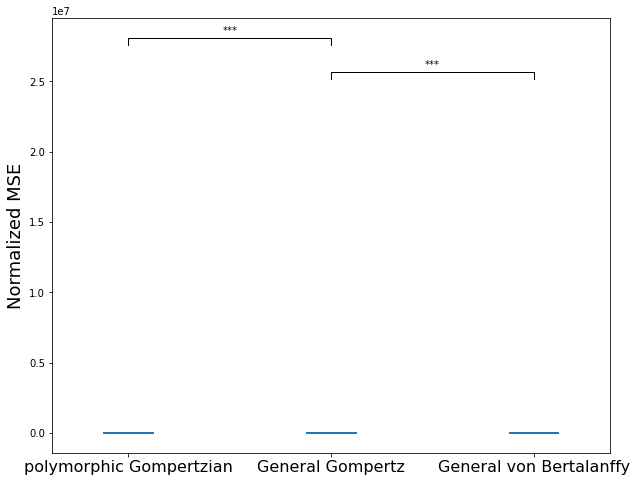

In [41]:
plt.figure(figsize=(10, 8))
plt.violinplot([nMSE, nMSE_GenGomp, nMSE_GenBer][::-1],
               positions =[3,2,1],vert=True,showmeans=True)
plt.xticks([1,2,3], ['polymorphic Gompertzian', 'General Gompertz',
                     'General von Bertalanffy'], fontsize=16)
plt.ylabel('Normalized MSE', size = 18)
#plotStats([nMSE, nMSE_GenGomp, nMSE_GenBer], 1)
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.1 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.005)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')   
plt.show()